In [3]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pylab as plt
import sys
from scipy.sparse.linalg import eigs

def read_file(filename):
    data = []
    with open(filename) as file:
        content = csv.reader(file)
        for c in content:
            data.append(c)
    return np.matrix(data).astype(np.float32)

#############################
#### PART A - MARKOV CHAIN
#############################
class markov_chain(object):
    
    def __init__(self, size, file_m, file_names):
        
        self.n = 763
        #initialize M:
        self.M = np.zeros((self.n,self.n))

        #generate M from file:
        self.create_matrix_from_file(file_m)
        self.read_team_names(file_names)

        #get eigen value:
        self.get_eigen_vector()

    
    def create_matrix_from_file(self,file):
        
        #load info into it:
        with open(file) as f:
            for row in f:
                teamA, ptsA, teamB, ptsB = [int(x) for x in 
                                    row.rstrip('\n').split(',')]
                # print(teamA, ptsA, teamB, ptsB)

                a_weight = ptsA/(ptsA+ptsB)
                a_wins = int(ptsA > ptsB)

                i = teamA-1
                j = teamB-1
                self.M[i,i] += a_wins + a_weight
                self.M[j,i] += a_wins + a_weight
                self.M[j,j] += 1-a_wins + 1-a_weight
                self.M[i,j] += 1-a_wins + 1-a_weight

        # print(np.sum(self.M))
        # print(self.M)
        #normalize M:
        self.M = self.M / np.sum(self.M, axis=1).reshape(-1,1)
        # print(self.M)

        # print(np.sum(self.M,axis=1))

    def read_team_names(self,file):
        
        #load info into it:
        with open(file) as f:
            self.team_names = np.array([x.rstrip('\n') 
                                       for x in f.readlines()])
    
    def get_eigen_vector(self):
        # w,v = np.linalg.eig(self.M)
        # print(max(w),w)
        # max_ind = np.where(w==max(w))[0][0]
        # print(max_ind) 
        # self.w_inf = v[:,max_ind]
        # rearrangedEvalsVecs = sorted(zip(evals,evecs.T),\
        #                             key=lambda x: x[0].real, reverse=True)
        self.w_inf = eigs(self.M.T,1)[1].flatten()
        #make sum 1:
        # print(self.w_inf[:5])
        self.w_inf = self.w_inf / np.sum(self.w_inf)
        print(self.w_inf[:5])
        # print(self.w_inf.shape)
        

    def train(self, T):
        
        #initialize uniform:
        # w = np.zeros(self.n)
        # w[np.random.random_integers(0,self.n-1,1)] = 1
        w = np.repeat(1/763, 763)

        #store diff:
        self.diff = []
        t_ranks = np.logspace(1,4,4)
        self.results = pd.DataFrame(index=range(25),
                               columns=['ranks']+["t_%d"%i for i in t_ranks])
        self.results['ranks'] = list(range(1,26))
        #run iterations:
        for t in range(T):
            w = np.dot(w,self.M)
            # print((w-self.w_inf).shape)
            # w = w/np.sum(w)
            # print(sum(w))
            self.diff.append(np.sum(np.abs(w-self.w_inf)))

            if (t+1) in t_ranks:
                word_idx = np.argsort(w)[::-1][:25]
                self.results["t_%d"%(t+1)] = list(zip(
                        self.team_names[word_idx],
                        [format(x, '.3f') for x in w[word_idx]]))


                self.team_names[np.argsort(w)[::-1][:25]]
            


def mchain():

    T=10000
    n_teams = 763

    #create a class object:
    mc = markov_chain(n_teams, 'CFB2017_scores.csv', 'TeamNames.txt')
    mc.train(T)

    #plot diff variation:
    plt.figure()
    plt.plot(range(1,T+1),mc.diff)

    plt.xticks(np.linspace(1,T,9))
    plt.xlabel('Iterations')
    plt.ylabel('1-norm between w_inf and w_t')
    plt.title('Variation of difference between w_inf and w_t with iterations')
    plt.savefig('hw5_1b.png')
    plt.show()

    #export results:

    mc.results.to_csv('hw5_1a.csv',index=False)

#############################
#### PART B - NMF
#############################

class NMF(object):

    def __init__(self, file_doc, file_vocab, 
                 d=25, ndoc=8447, nvocab=3012):
        
        self.ndoc = ndoc
        self.nvocab = nvocab
        self.d=d
        
        #initialize doc file:
        self.X = np.zeros((nvocab,ndoc))
        self.create_matrix_from_file(file_doc)
        self.load_words(file_vocab)

        #initialize W, H:
        self.W = np.random.uniform(1,2,(self.nvocab,self.d))
        self.H = np.random.uniform(1,2,(self.d,self.ndoc))

        # print(self.W)

    
    def create_matrix_from_file(self,file):
        # load info into it:
        dinc=0
        with open(file) as f:
            for row in f:
                wordcounts = row.rstrip('\n').split(',')
                # print(val)
                for wc in wordcounts:
                    ind,cnt = [int(x) for x in wc.split(':')]
                    self.X[ind-1,dinc] = cnt
                dinc+=1
        # print(self.X)

    def load_words(self,file):
        
        with open(file) as f:
            self.words = np.array([x.rstrip('\n') 
                                       for x in f.readlines()])
    
    def train(self,T):

        self.objective = []

        WH = self.W.dot(self.H)
        A = self.X/(WH+1e-16)
        
        for i in range(T):
            if i%10==0:
                print(i)

            # print(np.multiply(self.H, self.W.T.dot(A)).shape)
            self.H = np.multiply(self.H, self.W.T.dot(A))/np.sum(self.W,axis=0).reshape(self.d,1)
            WH = self.W.dot(self.H)
            A = self.X/(WH+1e-16)
            self.W = np.multiply(self.W, A.dot(self.H.T))/np.sum(self.H,axis=1).reshape(1,self.d)

            # print(np.sum(self.H,axis=0))
            # print(np.sum(self.W,axis=1))
            WH = self.W.dot(self.H)
            A = self.X/(WH+1e-16)

            obj = np.sum(np.multiply(np.log(1/(WH+1e-16)),self.X) + WH)
            self.objective.append(obj)

    def get_words(self):
        #normalize W:
        self.W = self.W / (np.sum(self.W, axis=0).reshape(1,-1))
        word_idx = np.apply_along_axis(lambda x: np.argsort(x)[-10:][::-1],
                                  axis=0,arr=self.W)
        results = pd.DataFrame(index=range(10),
                              columns=['Topic_%d'%i for i in range(1,26)])
        # resuts = pd.DataFrame(index=range(5),
        #                       columns=range(5))
        # resuts['Topic'] = list(range(1,26))
        for i in range(25):
            # print(self.W[word_idx[:,i],i])
            results.iloc[:,i] = list(zip([format(x, '.3f') for x in 
                                                    self.W[word_idx[:,i],i]],
                                        self.words[word_idx[:,i]]))
        
        print(results)
        results.to_csv('hw5_2b_words.csv',index=False)



def nmf(fdoc, fvocab):
    T = 100

    nmf = NMF(fdoc, fvocab)
    nmf.train(T)
    nmf.get_words()
    # print(mf.R)

    plt.figure()
    plt.plot(range(1,T+1),nmf.objective)
    plt.xticks(np.linspace(1,T,10))
    plt.xlabel('Iterations')
    plt.ylabel('Objective')
    plt.title('Variation of objective with iterations')
    plt.savefig('hw5_2a.png')
    plt.show()


def main():
    args = sys.argv

    #call naive bayes
    if 'mchain' in args:
        mchain()

    if 'nmf' in args:
        trainf = "data/nyt_data.txt"
        testf = "data/nyt_vocab.dat"
        nmf(trainf, testf)


if __name__ == "__main__":
    main()

0
10
20
30
40
50
60
70
80
90
            Topic_1            Topic_2              Topic_3  \
0   (0.015, health)    (0.021, police)      (0.030, charge)   
1  (0.014, program)      (0.020, kill)        (0.020, case)   
2     (0.011, care)    (0.013, attack)       (0.019, trial)   
3     (0.011, drug)  (0.013, official)      (0.019, lawyer)   
4    (0.010, study)   (0.012, officer)       (0.017, crime)   
5   (0.009, doctor)       (0.010, man)    (0.015, criminal)   
6  (0.008, medical)      (0.010, fire)      (0.014, prison)   
7  (0.008, provide)    (0.009, report)      (0.014, police)   
8  (0.008, problem)      (0.008, city)  (0.013, prosecutor)   
9    (0.008, child)     (0.007, carry)      (0.013, arrest)   

                Topic_4            Topic_5              Topic_6  \
0          (0.023, art)       (0.025, law)        (0.016, vote)   
1       (0.014, artist)      (0.017, rule)    (0.016, campaign)   
2       (0.010, museum)     (0.016, court)   (0.014, political)   
3   (0.00

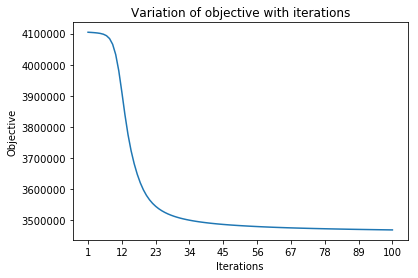

In [4]:
nmf("nyt_data.txt", "nyt_vocab.dat")

In [12]:
def nmf_function(file_doc, file_vocab, T):
    ndoc = 8447
    d = 25
    nvocab = 3012
    
    X = np.zeros((nvocab,ndoc))
    
    temp_var = 0
    with open(file_doc) as f:
        for row in f:
            wordcounts = row.rstrip('\n').split(',')
            for y in wordcounts:
                ind,cnt = [int(x) for x in y.split(':')]
                X[ind-1,temp_var] = cnt
            temp_var+=1
    
    with open(file_vocab) as file:
        words = np.array([a.rstrip('\n') for a in file.readlines()])


    W = np.random.uniform(1,2,(nvocab,d))
    H = np.random.uniform(1,2,(d,ndoc))
    
    objective = []

    WH = W.dot(H)
    A = X/(WH+1e-16)

    for i in range(T):

        H = np.multiply(H, W.T.dot(A))/np.sum(W,axis=0).reshape(d,1)
        WH = W.dot(H)
        A = X/(WH+1e-16)
        W = np.multiply(W, A.dot(H.T))/np.sum(H,axis=1).reshape(1,d)

        WH = W.dot(H)
        A = X/(WH+1e-16)

        obj = np.sum(np.multiply(np.log(1/(WH+1e-16)),X) + WH)
        objective.append(obj)

        
        
        W = W / (np.sum(W, axis=0).reshape(1,-1))
        word_idx = np.apply_along_axis(lambda x: np.argsort(x)[-10:][::-1],axis=0,arr=W)
        results = pd.DataFrame(index=range(10),columns=['topic_%d'%i for i in range(1,26)])
        for i in range(25):
            results.iloc[:,i] = list(zip([format(x, '.3f') for x in W[word_idx[:,i],i]],words[word_idx[:,i]]))
        
        results.to_csv('hw5_2b_words.csv',index=False)
        
    plt.figure()
    plt.plot(range(1,T+1),objective)
    plt.xticks(np.linspace(1,T,10))
    plt.xlabel('Iterations')
    plt.ylabel('Objective')
    plt.title('Variation of objective with iterations')
    plt.savefig('hw5_2a.png')
    plt.show()
    


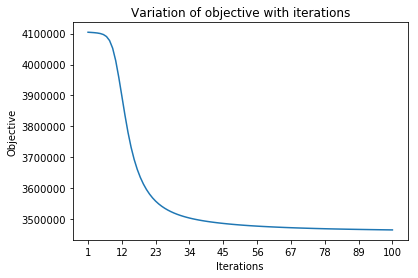

In [13]:
nmf_function("nyt_data.txt", "nyt_vocab.dat", 100)

In [18]:

import numpy
def nmf_function(data_file, vocab_file, T):
    
    vocab_length = 3012
    doc_length = 8447
    d = 25
    W = numpy.random.uniform(1,2,(vocab_length,d))
    H = numpy.random.uniform(1,2,(d,doc_length))
    X = numpy.zeros((vocab_length,doc_length))
    
    temp_var = 0
    with open(data_file) as f:
        for row in f:
            nwords = row.rstrip('\n').split(',')
            for y in nwords:
                a,b = [int(x) for x in y.split(':')]
                X[a-1,temp_var] = b
            temp_var+=1
    
    with open(vocab_file) as file:
        words = numpy.array([a.rstrip('\n') for a in file.readlines()])


    obj_list = []
    WH = W.dot(H)
    temp_matrix = X/(WH+1e-16)

    for i in range(T):

        var_temp = numpy.sum(W,axis=0).reshape(d,1)
        H = numpy.multiply(H, W.T.dot(temp_matrix))/ var_temp
        WH = W.dot(H)
        temp_matrix = X/(WH+1e-16)
        var_temp = numpy.sum(H,axis=1).reshape(1,d)
        W = numpy.multiply(W, temp_matrix.dot(H.T))/ var_temp

        WH = W.dot(H)
        temp_matrix = X/(WH+1e-16)

        obj = numpy.sum(numpy.multiply(numpy.log(1/(WH+1e-16)),X) + WH)
        obj_list.append(obj)

        W = W / (numpy.sum(W, axis=0).reshape(1,-1))
        word_index = numpy.apply_along_axis(lambda x: numpy.argsort(x)[-10:][::-1],axis=0,arr=W)
        answer = pd.DataFrame(index=range(10),columns=['topic %d'%i for i in range(1,26)])
        for i in range(25):
            answer.iloc[:,i] = list(zip([format(x, '.3f') for x in W[word_index[:,i],i]],words[word_index[:,i]]))
        
        answer.to_csv('q2_b.csv',index=False)
        
    plt.figure()
    plt.plot(range(1,T+1),obj_list)
    plt.xticks(numpy.linspace(1,T,5))
    plt.xlabel('Iterations')
    plt.title('Objective function for iterations')
    plt.show()
    




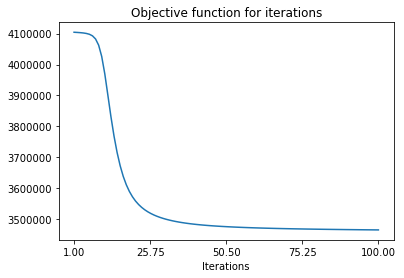

In [19]:
nmf_function("nyt_data.txt", "nyt_vocab.dat", 100)